# Data set 2<br>
This dataset consists of time series of reported cases of chickenpox at the county level between 2005 and 2015. The dataset can be used for both county-level and nation-level case count prediction. For this work, the counts per county were used. For the experiments involving the addition of rows, the Primary Source contained records from 2005 to 2013, and the last two years were treated as a new block of records.<br>
## Preliminaries<br>
Import and load the uses Python packages and modules:

In [1]:
import sys
import os
# Add the parent directory to sys.path
parent_directory = os.path.abspath(os.path.join(os.getcwd(), '../main/'))
sys.path.insert(0, parent_directory)
import pandas as pd
import numpy as np
import sim_experiments as smexp_dyn
from datetime import date
import autoversion_service as av
import autoversion_aemod as avae

Load the data set and prepare it:

In [2]:
df = pd.read_csv("../datasets/ds02-hungary_chickenpox.csv")
df["Date"] = pd.to_datetime(df.Date, format = '%d/%m/%Y')
dfnum = df.select_dtypes(include=[float, int])
dfnum.index = df["Date"]
n_samples_ps = np.min(np.where(df["Date"]>="2010"))
print(str(n_samples_ps) + "(" + str(np.round(n_samples_ps/len(dfnum)*100,2)) + ")")

261(50.0)


In [3]:
X_PS = dfnum.iloc[:n_samples_ps+1,]
X_NEW = dfnum.iloc[n_samples_ps+1:,]

Exploratory analysis showing time series decomposigion as an additive model where each time instant ($x_i$) is the addition of a trend component ($T_i$), a seasonal component ($S_i$) and an error component ($E_i$)

In [4]:
smexp_dyn.plot_time_components_div(dfnum, X_PS.index, X_NEW.index, 52, xplot_ps=X_PS.index, xplot_rev=X_NEW.index, dsname="ds02comb", xtxtsize=5, path_figs="../figures/")

'done'

## Primary Source models<br>
Obtain the parameters for the reference batch of data. The function returns a dictionary *ps_dict* with the parameters to compute each one of the drift metrics according to a different ML model and the _indPS_ variable with the indices of the records used for the reference set.

Doing Primary Source Model -- 
N = 262 (50.19 % of total dataset length)
Step [1/6]: Printing the Original Data Set Features =======
Step [1/6]: Starting ...
         BUDAPEST     BARANYA        BACS       BEKES      BORSOD    CSONGRAD  \
count  262.000000  262.000000  262.000000  262.000000  262.000000  262.000000   
mean   104.980916   37.030534   39.312977   39.622137   61.293893   36.667939   
std     81.614619   32.086077   33.217981   46.078543   53.135782   37.808760   
min      2.000000    0.000000    0.000000    0.000000    1.000000    0.000000   
25%     35.000000    8.250000   10.000000    7.000000   18.250000    7.250000   
50%     98.000000   31.000000   34.000000   22.000000   51.500000   25.500000   
75%    152.250000   58.750000   58.000000   57.000000   89.750000   50.500000   
max    479.000000  145.000000  153.000000  271.000000  355.000000  199.000000   

            FEJER        GYOR       HAJDU       HEVES        JASZ     KOMAROM  \
count  262.000000  262.000000  

2023-11-24 18:31:44.567135: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Model: "my_ae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 16)                336       
                                                                 
 sequential_1 (Sequential)   (None, 20)                340       
                                                                 
Total params: 676
Trainable params: 676
Non-trainable params: 0
_________________________________________________________________
Best model - DONE
2/2 [==============================] - 0s 1ms/step
Data model -  DONE
Permutation test -  DONE
dE-AE summary: 63.22676396369934 s.; 640 b.
Step [3/6]: Finished.


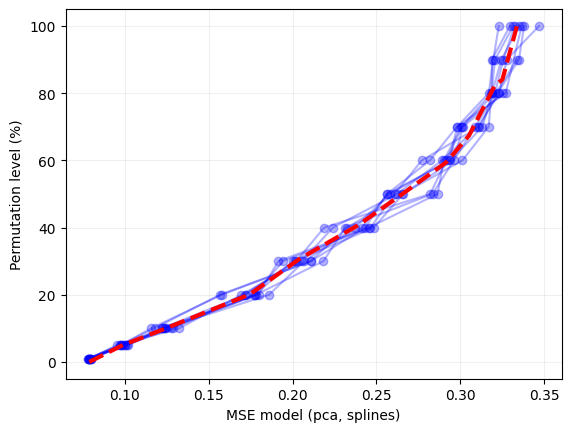

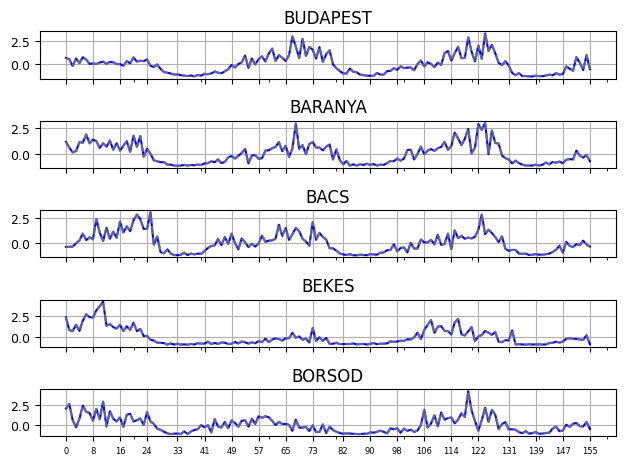

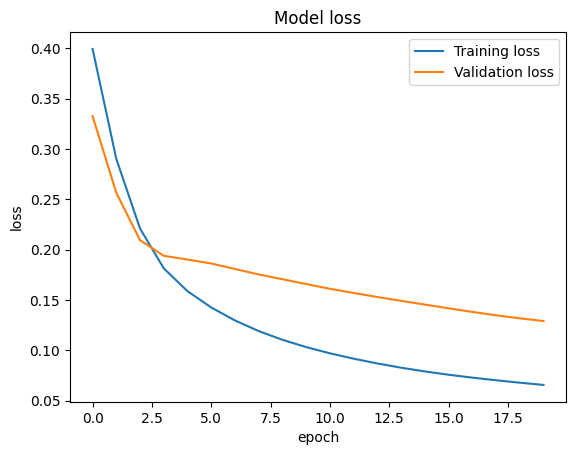

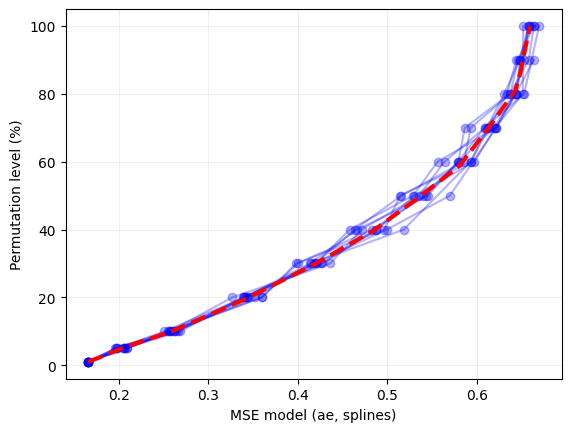

In [5]:
import random
import tensorflow as tf
tf.random.set_seed(42) 
np.random.seed(42)
random.seed(42)
print("Doing Primary Source Model -- \n" + "N = " + str(len(X_PS)) + " (" + str(np.round(len(X_PS)/(len(X_PS) + len(X_NEW))*100,2)) + " %" + " of total dataset length)")
ps_dict, ind_PS = smexp_dyn.get_PS_data(X_PS, resultspath = "../results/ds02-demo/", dstitle = "DS 02 PS", 
                                        PSfilename = "ds02ps.pkl", mse_model_type="splines", pctge_PS=1, resultsfile="dyn-ds-02")

### New versions<br>
When a new version of the dataset is generated, it will be compared to the information from the previous version in the following way:<br>
  * $d_{P}$: computes the cosine distance between loading matrices obtained for both data sets;<br>
  * $d_{E, PCA}$: computes the MSE obtained by reconstructing the new batch using the reference PCA model. This value is fed into a quadratic model fitted with the reference data set, which relates MSE values to levels of corruption artificially simulated by permuting entries from the reference set.<br>
  * $d_{E, AE}$: computes the MSE obtained by reconstructing the new batch using the reference AE model. This value is fed into a quadratic model fitted with the reference data set, which relates MSE values to levels of corruption artificially simulated by permuting entries from the reference set.<br>


## Creation events<br>
The following experiments use an initial subset as reference, emulating the scenario of dynamic update with batches of different size.

In [6]:
print("  - Case 1: add rows of new set \n")
# Add batches of 10% New Dataset records' size
ds02_c_demo = smexp_dyn.do_exp(X_NEW, ps_dict, resultspath = "../results/ds02-demo", mod_pca = True, mod_ae = True, 
                  mode_der = "add_batch", batchsize_pctges = [0.1], demo = True,
                  dstitle="DS 02 creation-demo", kfolds=0, resultsfile="/demo-ds02-creation")

__, vC_pca_dp = av.versionDER(ds02_c_demo, ps_dict["PS_dic"]["PCA"]["S"], outdict=True, loadfile=False, dstitle="DS 02 creation-demo pca-dP", cat_threshold=2)
__, vC_pca_de = av.versionDER(ds02_c_demo, ps_dict["PS_dic"]["PCA"]["E"], outdict=True, loadfile=False, dstitle="DS 02 creation-demo pca-dE", drift_dist="dE", 
                                  cat_threshold = 2)
vC_ae_de = avae.versionDER(ds02_c_demo, ps_dict["PS_dic"]["AE"], "../results/ds02-demo/aelogs/tb_logs", "../results/ds02-demo", outdict=True, loadfile=False, 
                               dstitle="DS 02 creation-demo ae", cat_threshold = 2)

print("DS 02 - PS - v.tag: " + ps_dict["PS_dic"]["PCA"]["S"]["vtag"])
print("DS 02 - demo creation - PCA dP v.tag: " + vC_pca_dp["vtag"])
print("DS 02 - demo creation - PCA dE v.tag: " + vC_pca_de["vtag"])
print("DS 02 - demo creation - AE v.tag: " + vC_ae_de["vtag"])

  - Case 1: add rows of new set 

New versions, level 0.1- start
DS 02 - PS - v.tag: 1.0.<11/24/2023 - 17:31:40>
DS 02 - demo creation - PCA dP v.tag: 1.44.<11/24/2023 - 17:32:46>
DS 02 - demo creation - PCA dE v.tag: 1.30.<11/24/2023 - 17:32:46>
DS 02 - demo creation - AE v.tag: 1.25.<11/24/2023 - 17:32:46>


## Update events<br>

In [7]:
print("  - Case 2: transform columns ..\n")

ds02_u_demo = smexp_dyn.do_exp(X_PS, ps_dict, resultspath = "../results/ds02-demo", mode_der = "trans_cols",
                    tr_pctges = [0.5], dstitle="DS 02 update-demo", batchsize_pctges=[1], kfolds=1,
                    modetr="cbrt",resultsfile="/demo-ds02-trcols-cbrt", demo = True)

__, vU_pca_dp = av.versionDER(ds02_u_demo, ps_dict["PS_dic"]["PCA"]["S"], outdict=True, loadfile=False, dstitle="DS 02 update-demo pca-dP", cat_threshold=2)
__, vU_pca_de = av.versionDER(ds02_u_demo, ps_dict["PS_dic"]["PCA"]["E"], outdict=True, loadfile=False, dstitle="DS 02 update-demo pca-dE", drift_dist="dE", 
                                  cat_threshold = 2)
vU_ae_de = avae.versionDER(ds02_u_demo, ps_dict["PS_dic"]["AE"], "../results/ds02-demo/aelogs/tb_logs", "../results/ds02-demo", outdict=True, loadfile=False, 
                               dstitle="DS 02 update-demo ae", cat_threshold = 2)

print("DS 02 - PS - v.tag: " + ps_dict["PS_dic"]["PCA"]["S"]["vtag"])
print("DS 02 - demo update - PCA dP v.tag: " + vU_pca_dp["vtag"])
print("DS 02 - demo update - PCA dE v.tag: " + vU_pca_de["vtag"])
print("DS 02 - demo update - AE v.tag: " + vU_ae_de["vtag"])

  - Case 2: transform columns ..

New versions, level [0.5]- start
DS 02 - PS - v.tag: 1.0.<11/24/2023 - 17:31:40>
DS 02 - demo update - PCA dP v.tag: 2.19.<11/24/2023 - 17:32:46>
DS 02 - demo update - PCA dE v.tag: 2.13.<11/24/2023 - 17:32:46>
DS 02 - demo update - AE v.tag: 2.24.<11/24/2023 - 17:32:46>


## Deletion events<br>
In the following cases, the reference set contains all the records and some of them are deleted in different ways: signals are down sampled, outliers are removed, etc.

In [8]:
print("  - Case 3: remove rows decimate .. \n")
ds02_d_demo = smexp_dyn.do_exp(X_PS, ps_dict, resultspath = "../results/ds02-demo", mode_der = "rem_rows_decimate",
                    tr_pctges = [0.5], dstitle="DS 02 deletion-demo", batchsize_pctges=[1], resultsfile="/demo-ds02-deletion", 
                    demo = True)

__, vD_pca_dp = av.versionDER(ds02_d_demo, ps_dict["PS_dic"]["PCA"]["S"], outdict=True, loadfile=False, dstitle="DS 02 deletion-demo pca-dP", cat_threshold=2)
__, vD_pca_de = av.versionDER(ds02_d_demo, ps_dict["PS_dic"]["PCA"]["E"], outdict=True, loadfile=False, dstitle="DS 02 deletion-demo pca-dE", drift_dist="dE", 
                                  cat_threshold = 2)
vD_ae_de = avae.versionDER(ds02_d_demo, ps_dict["PS_dic"]["AE"], "../results/ds02-demo/aelogs/tb_logs", "../results/ds02-demo", outdict=True, loadfile=False, 
                               dstitle="DS 02 deletion-demo ae", cat_threshold = 2)

print("DS 02 - PS - v.tag: " + ps_dict["PS_dic"]["PCA"]["S"]["vtag"])
print("DS 02 - demo deletion - PCA dP v.tag: " + vD_pca_dp["vtag"])
print("DS 02 - demo deletion - PCA dE v.tag: " + vD_pca_de["vtag"])
print("DS 02 - demo deletion - AE v.tag: " + vD_ae_de["vtag"])

  - Case 3: remove rows decimate .. 

New versions, level [0.5]- start
DS 02 - PS - v.tag: 1.0.<11/24/2023 - 17:31:40>
DS 02 - demo deletion - PCA dP v.tag: 1.15.<11/24/2023 - 17:32:46>
DS 02 - demo deletion - PCA dE v.tag: 1.0.<11/24/2023 - 17:32:46>
DS 02 - demo deletion - AE v.tag: 1.4.<11/24/2023 - 17:32:46>


In [9]:
demo_results = pd.DataFrame({"datasets": "ds02-demo", 
                "PS": {"dPCA_P": ps_dict["PS_dic"]["PCA"]["S"]["vtag"], "dPCA_E":  ps_dict["PS_dic"]["PCA"]["E"]["vtag"], 
                       "dAE_E": ps_dict["PS_dic"]["AE"]["vtag"]},
                "creation": {"dPCA_P": vC_pca_dp["vtag"], "dPCA_E": vC_pca_de["vtag"], "dAE_E": vC_ae_de["vtag"]},
                "update": {"dPCA_P": vU_pca_dp["vtag"], "dPCA_E": vU_pca_de["vtag"], "dAE_E": vU_ae_de["vtag"]}, 
                "deletion": {"dPCA_P": vD_pca_dp["vtag"], "dPCA_E": vD_pca_de["vtag"], "dAE_E": vD_ae_de["vtag"]}})
if os.path.exists("../results/demos.xlsx"):
       with pd.ExcelWriter("../results/demos.xlsx", engine="openpyxl", mode="a", if_sheet_exists="replace") as writer:
              demo_results.to_excel(writer, sheet_name="ds02")
else:
       demo_results.to_excel("../results/demos.xlsx", sheet_name='ds02')  